In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Deep Convolutional Library
# Batch Normalization and Drop outs are used to optimise the value and to avoid overfitting
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose, LeakyReLU, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

In [4]:
folder_path="/kaggle/input/anime-dataset/images"

In [5]:
images_files = [f for f in os.listdir(folder_path) if f.endswith(('png','jpg','jpeg'))]

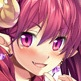

In [6]:
Image.open(os.path.join(folder_path ,images_files[1]))

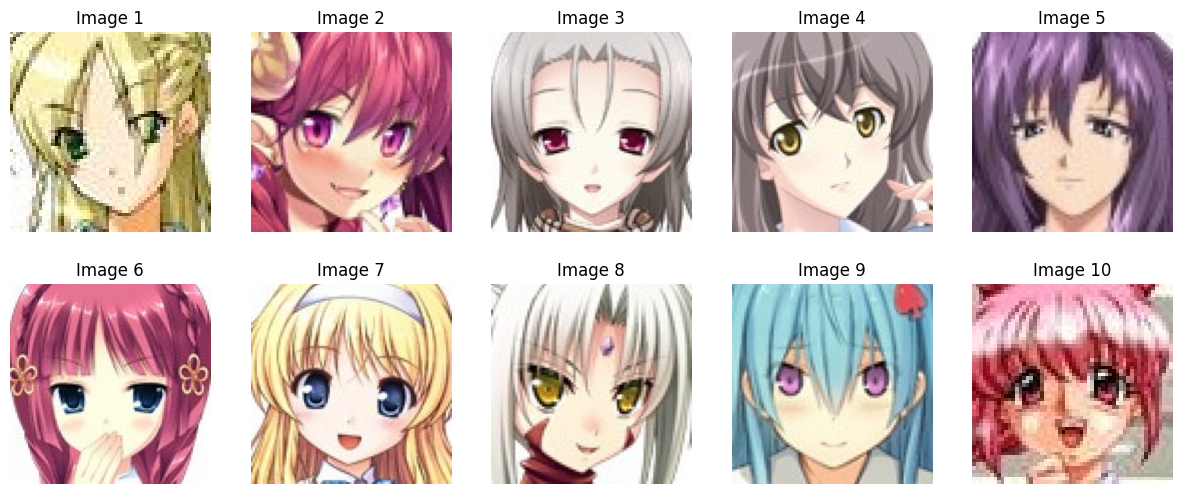

In [7]:
fig, axes = plt.subplots(2, 5, figsize = (15,6))

for i, ax in enumerate(axes.flat):
    img_path = os.path.join(folder_path ,images_files[i])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Image {i + 1}")
    ax.axis('off')
plt.show()

#### Image Data Augmentation
* Tranformation of input image and prepare training sample image

In [8]:
# rescale : It will rescale image pixel value from 0-255 to 0-1
train_datagen = ImageDataGenerator(rescale = 1./255, brightness_range = [0.8,1.2], horizontal_flip = True)
training_set = train_datagen.flow_from_directory("/kaggle/input/anime-dataset", target_size = (64, 64), batch_size = 32,
                                  class_mode = None)

Found 63565 images belonging to 1 classes.


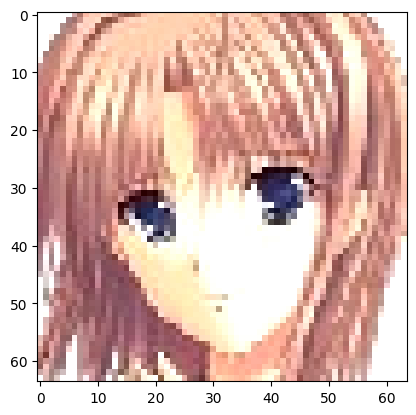

In [9]:
plt.imshow(training_set[0][0])

#### Deep Convolution Generative Adversial Network
    * Generative Model
    * Discriminative model

In [10]:
KI = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
input_dim = 300

def Generator_Model():

    Generator = Sequential()

    # Random Noise
    Generator.add(Dense(8 * 8 * 512, input_dim = input_dim))
    Generator.add(ReLU())
    # Convert 1D to 3D
    Generator.add(Reshape((8, 8, 512)))
    # Upsample
    Generator.add(Conv2DTranspose(256, (4,4), strides = (2,2), padding = 'same', kernel_initializer=KI, activation = 'relu'))
    Generator.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same', kernel_initializer=KI, activation = 'relu'))
    Generator.add(Conv2DTranspose(64, (4,4), strides = (2,2), padding = 'same', kernel_initializer=KI, activation = 'relu'))
    Generator.add(Conv2D(3, (4,4), padding = 'same', activation = 'sigmoid'))

    return Generator

In [11]:
generator = Generator_Model()

In [12]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32768)               │       9,863,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,619,203 (48.14 MB)

 Trainable params: 12,619,203 (48.14 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
def Discriminator_Model():
    # Sequential Model
    discriminator = Sequential()
    # num of filters = 64, kernel_size = (3,3), activation = relu function
    discriminator.add(Conv2D(64, kernel_size = (3, 3), strides = (1,1), activation = 'leaky_relu',
                             padding = 'same', input_shape = (64, 64, 3)))

    discriminator.add(MaxPooling2D())
    discriminator.add(Conv2D(128, kernel_size = (3, 3), strides = (1,1), activation = 'leaky_relu',
                             padding = 'same'))

    discriminator.add(MaxPooling2D())
    discriminator.add(Conv2D(256, kernel_size = (3, 3), strides = (1,1), activation = 'leaky_relu',
                             padding = 'same'))

    discriminator.add(MaxPooling2D(pool_size = (2,2)))
    discriminator.add(Flatten())
    # Fully-Connected Layer
    discriminator.add(Dense(512, activation = 'leaky_relu'))
    discriminator.add(Dense(1, activation = 'sigmoid'))

    return discriminator

In [14]:
discriminator=Discriminator_Model()

In [15]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,760,449 (33.42 MB)

 Trainable params: 8,760,449 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
class DCGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim = input_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

        # compute discriminator gradients (dE/dW)
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)

        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [17]:
class DCGANMonitor(tf.keras.callbacks.Callback):
    # Intialization of variables
    def __init__(self, num_imgs = 25, latent_dim = input_dim):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    # Once 1 Epoch Ends
    def on_epoch_end(self, epoch, logs = None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 255) + 255
        g_img.numpy()

    # save model after training
    def on_train_end(self, logs = None):
        self.model.generator.save("DCGANKeras.keras")

In [18]:
latent_dim = 300     # Input shape
epochs = 30          # num of iterations
lr_g = 0.0001        # learning rate (alpha)   0.0001 - 1.0
lr_d = 0.0001
beta = 0.5

In [19]:
# Call class DCGAN
dcgan = DCGAN(generator = generator, discriminator = discriminator, latent_dim = latent_dim)

In [20]:
# Call class DCGAN
from tensorflow.keras.losses import BinaryCrossentropy

dcgan.compile(g_optimizer = Adam (learning_rate = lr_g, beta_1 = beta), 
              d_optimizer = Adam (learning_rate = lr_g, beta_1 = beta),
              loss_fn = BinaryCrossentropy())

In [21]:
history = dcgan.fit(training_set, epochs = epochs, callbacks = [DCGANMonitor()])


Epoch 1/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 494s 243ms/step - d_loss: 0.1654 - g_loss: 3.3919
Epoch 2/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 87s 44ms/step - d_loss: 0.1382 - g_loss: 3.9987
Epoch 3/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - d_loss: 0.1230 - g_loss: 4.4027
Epoch 4/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - d_loss: 0.0777 - g_loss: 4.8333
Epoch 5/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - d_loss: 0.0795 - g_loss: 5.5750
Epoch 6/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - d_loss: 0.0821 - g_loss: 5.6206
Epoch 7/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 85s 43ms/step - d_loss: 0.0873 - g_loss: 5.8655
Epoch 8/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - d_loss: 0.0902 - g_loss: 5.4928
Epoch 9/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - d_loss: 0.0973 - g_loss: 5.2260
Epoch 10/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 84s 42ms/step - d_loss: 0.0925 - g_loss: 4.9341
Epoch 11/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 84s 42ms/step - d_loss: 0.1051 - g_loss: 5.1811
Epoch 

In [22]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.to_csv("history.csv")

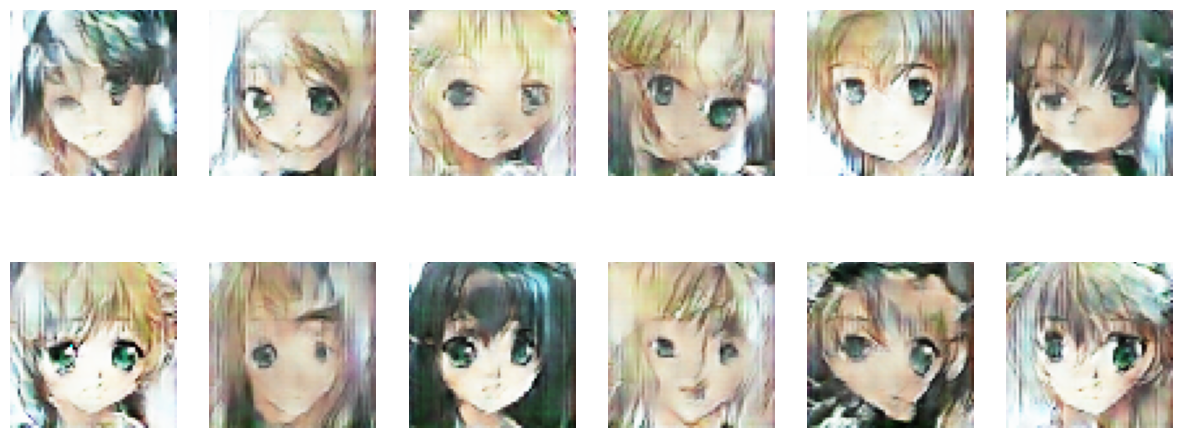

In [23]:
plt.figure(figsize=(15, 6))

for i in range(12):
    plt.subplot(2, 6, i + 1)
    # Generate random noise for each image
    noise = tf.random.normal([1, 300])
    mg = dcgan.generator(noise)
    # Denormalize
    mg = (mg * 255) + 255

    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))

    plt.imshow(image)
    plt.axis('off')

plt.show()